# Exam 2021, 8.00-13.00 for the course 1MS041 (Introduction to Data Science / Introduktion till dataanalys)

## Instructions:
1. Complete the problems by following instructions.
2. When done, submit this file with your solutions saved, following the instruction sheet.

This exam has 3 problems for a total of 40 points, to pass you need
20 points.

## Some general hints and information:
* Try to answer all questions even if you are uncertain.
* Comment your code, so that if you get the wrong answer I can understand how you thought
this can give you some points even though the code does not run.
* Follow the instruction sheet rigorously.
* This exam is partially autograded, but your code and your free text answers are manually graded anonymously.
* If there are any questions, please ask the exam guards, they will escalate it to me if necessary.
* I (Benny) will visit the exam room at around 10:30 to see if there are any questions.

## Tips for free text answers
* Be VERY clear with your reasoning, there should be zero ambiguity in what you are referring to.
* If you want to include math, you can write LaTeX in the Markdown cells, for instance `$f(x)=x^2$` will be rendered as $f(x)=x^2$ and `$$f(x) = x^2$$` will become an equation line, as follows
$$f(x) = x^2$$
Another example is `$$f_{Y \mid X}(y,x) = P(Y = y \mid X = x) = \exp(\alpha \cdot x + \beta)$$` which renders as
$$f_{Y \mid X}(y,x) = P(Y = y \mid X = x) = \exp(\alpha \cdot x + \beta)$$

## Finally some rules:
* You may not communicate with others during the exam, for example:
    * You cannot ask for help in Stack-Overflow or other such help forums during the Exam.
    * You may not communicate with AI's, for instance ChatGPT.
    * Your on-line and off-line activity is being monitored according to the examination rules.

## Good luck!

In [35]:
# Insert your anonymous exam ID as a string in the variable below
examID="XXX"


---
## Exam vB, PROBLEM 1
Maximum Points = 8


## Probability warmup
Let's say we have an exam question which consists of $20$ yes/no questions. 
From past performance of similar students, a randomly chosen student will know the correct answer to $N \sim \text{binom}(20,11/20)$ questions. Furthermore, we assume that the student will guess the answer with equal probability to each question they don't know the answer to, i.e. given $N$ we define $Z \sim \text{binom}(20-N,1/2)$ as the number of correctly guessed answers. Define $Y = N + Z$, i.e., $Y$ represents the number of total correct answers.

We are interested in setting a deterministic threshold $T$, i.e., we would pass a student at threshold $T$ if $Y \geq T$. Here $T \in \{0,1,2,\ldots,20\}$.

1. [5p] For each threshold $T$, compute the probability that the student *knows* less than $10$ correct answers given that the student passed, i.e., $N < 10$. Put the answer in `problem11_probabilities` as a list.
2. [3p] What is the smallest value of $T$ such that if $Y \geq T$ then we are 90\% certain that $N \geq 10$?

In [36]:
from scipy.special import binom as binomial

# Hint the PMF of N is p_N(k) where p_N is
p = 11/20
p_N = lambda k: binomial(20,k)*(1-p)**(20-k)*(p)**k

### Explanation for Part 1:

We need to find $P(N < 10 | Y \geq T)$ for each threshold $T$.

Using Bayes' theorem:
$$P(N < 10 | Y \geq T) = \frac{P(Y \geq T | N < 10) \cdot P(N < 10)}{P(Y \geq T)}$$

Where:
- $N \sim \text{Binomial}(20, 11/20)$ is the number of questions the student knows
- $Z | N \sim \text{Binomial}(20-N, 1/2)$ is the number of correct guesses
- $Y = N + Z$ is the total number of correct answers

To compute $P(Y \geq T)$, we need to sum over all possible values of $N$:
$$P(Y \geq T) = \sum_{n=0}^{20} P(Y \geq T | N=n) \cdot P(N=n)$$

Given $N=n$, we have $Z \sim \text{Binomial}(20-n, 1/2)$, so:
$$P(Y \geq T | N=n) = P(Z \geq T-n) = \sum_{z=\max(0,T-n)}^{20-n} \binom{20-n}{z} (1/2)^{20-n}$$

In [37]:
import numpy as np

def prob_Y_geq_T_given_N(T, n, total_questions=20):
    """
    Calculate P(Y >= T | N = n) where Y = N + Z and Z ~ Binomial(total_questions - n, 0.5)
    
    Parameters:
    -----------
    T : int
        The threshold for passing
    n : int
        The number of questions the student knows
    total_questions : int
        Total number of questions (default: 20)
        
    Returns:
    --------
    float : probability that Y >= T given N = n
    """
    remaining_questions = total_questions - n
    # We need Z >= T - n
    min_z = max(0, T - n)
    
    if min_z > remaining_questions:
        return 0.0
    
    # P(Z >= min_z) where Z ~ Binomial(remaining_questions, 0.5)
    prob = sum(binomial(remaining_questions, z) * (0.5)**remaining_questions 
               for z in range(min_z, remaining_questions + 1))
    return prob


def prob_Y_geq_T(T, p_N_func, total_questions=20):
    """
    Calculate P(Y >= T) by marginalizing over N
    
    Parameters:
    -----------
    T : int
        The threshold for passing
    p_N_func : callable
        Function that computes P(N = k)
    total_questions : int
        Total number of questions (default: 20)
        
    Returns:
    --------
    float : probability that Y >= T
    """
    prob = sum(prob_Y_geq_T_given_N(T, n, total_questions) * p_N_func(n) 
               for n in range(total_questions + 1))
    return prob


def prob_N_less_than_threshold_given_pass(T, n_threshold, p_N_func, total_questions=20):
    """
    Calculate P(N < n_threshold | Y >= T) using Bayes' theorem
    
    Parameters:
    -----------
    T : int
        The threshold for passing (Y >= T means pass)
    n_threshold : int
        We want P(N < n_threshold | Y >= T)
    p_N_func : callable
        Function that computes P(N = k)
    total_questions : int
        Total number of questions (default: 20)
        
    Returns:
    --------
    float : probability that N < n_threshold given Y >= T
    """
    # P(Y >= T and N < n_threshold)
    numerator = sum(prob_Y_geq_T_given_N(T, n, total_questions) * p_N_func(n) 
                    for n in range(n_threshold))
    
    # P(Y >= T)
    denominator = prob_Y_geq_T(T, p_N_func, total_questions)
    
    if denominator == 0:
        return 0.0
    
    return numerator / denominator

In [38]:
# Part 1: Calculate P(N < 10 | Y >= T) for each threshold T = 0, 1, 2, ..., 20
problem11_probabilities = [prob_N_less_than_threshold_given_pass(T, 10, p_N, 20) 
                           for T in range(21)]

problem11_probabilities

[0.24928935982841177,
 0.24928935982832875,
 0.24928935982261038,
 0.2492893596354927,
 0.24928935576839326,
 0.24928929915834958,
 0.2492886751893024,
 0.24928330207958446,
 0.24924628523366013,
 0.24903902630299046,
 0.2480856990043143,
 0.24460820014975926,
 0.2349439695781523,
 0.21475641513175908,
 0.18267139196620988,
 0.1427252244707204,
 0.10227042692681906,
 0.06762809950564576,
 0.041664724391227426,
 0.024151134340423375,
 0.013287462679601604]

### Explanation for Part 2:

We need to find the smallest $T$ such that we are 90% certain that $N \geq 10$ when $Y \geq T$.

This means we need: $P(N \geq 10 | Y \geq T) \geq 0.90$

Equivalently: $P(N < 10 | Y \geq T) \leq 0.10$

We can use our computed probabilities from Part 1 to find the smallest $T$ that satisfies this condition.

In [39]:
def find_min_threshold_for_certainty(probabilities, certainty_level=0.90):
    """
    Find the minimum threshold T such that P(N >= 10 | Y >= T) >= certainty_level
    
    Parameters:
    -----------
    probabilities : list
        List of P(N < 10 | Y >= T) for T = 0, 1, 2, ..., 20
    certainty_level : float
        Required certainty that N >= 10 (default: 0.90)
        
    Returns:
    --------
    int : minimum threshold T that satisfies the condition
    """
    max_prob_N_less_than_10 = 1 - certainty_level
    
    for T, prob in enumerate(probabilities):
        if prob <= max_prob_N_less_than_10:
            return T
    
    return len(probabilities) - 1  # If no threshold satisfies, return the maximum

In [40]:
# Part 2: Find the smallest T such that P(N >= 10 | Y >= T) >= 0.90
problem12_T = find_min_threshold_for_certainty(problem11_probabilities, 0.90)

problem12_T

17

### Verification of Results:

Let's verify our answers by checking some key values:

In [41]:
# Display probabilities around the threshold
print("Threshold T | P(N < 10 | Y >= T) | P(N >= 10 | Y >= T)")
print("-" * 55)
for T in range(15, 21):
    prob_less = problem11_probabilities[T]
    prob_geq = 1 - prob_less
    marker = " <-- Answer" if T == problem12_T else ""
    print(f"    {T:2d}      |      {prob_less:.6f}      |      {prob_geq:.6f}{marker}")

Threshold T | P(N < 10 | Y >= T) | P(N >= 10 | Y >= T)
-------------------------------------------------------
    15      |      0.142725      |      0.857275
    16      |      0.102270      |      0.897730
    17      |      0.067628      |      0.932372 <-- Answer
    18      |      0.041665      |      0.958335
    19      |      0.024151      |      0.975849
    20      |      0.013287      |      0.986713


In [42]:
# Verify the answer: at T=17, we should have P(N >= 10 | Y >= 17) >= 0.90
print(f"\nAt threshold T = {problem12_T}:")
print(f"P(N < 10 | Y >= {problem12_T}) = {problem11_probabilities[problem12_T]:.6f}")
print(f"P(N >= 10 | Y >= {problem12_T}) = {1 - problem11_probabilities[problem12_T]:.6f}")
print(f"\nThis means we are {(1 - problem11_probabilities[problem12_T])*100:.2f}% certain that N >= 10")
print(f"when a student passes with threshold T = {problem12_T}.")


At threshold T = 17:
P(N < 10 | Y >= 17) = 0.067628
P(N >= 10 | Y >= 17) = 0.932372

This means we are 93.24% certain that N >= 10
when a student passes with threshold T = 17.


---
## Exam vB, PROBLEM 2
Maximum Points = 8


## Random variable generation and transformation

The purpose of this problem is to show that you can implement your own sampler, this will be built in the following three steps:

1. [2p] Implement a Linear Congruential Generator where you tested out a good combination (a large $M$ with $a,b$ satisfying the Hull-Dobell (Thm 6.8)) of parameters. Follow the instructions in the code block.
2. [2p] Using a generator construct random numbers from the uniform $[0,1]$ distribution.
3. [4p] Using a uniform $[0,1]$ random generator, generate samples from 

$$p_0(x) = \frac{\pi}{2}|\sin(2\pi x)|, \quad x \in [0,1] \enspace .$$

Using the **Accept-Reject** sampler (**Algorithm 1** in TFDS notes) with sampling density given by the uniform $[0,1]$ distribution.

### Explanation for Part 1: Linear Congruential Generator (LCG)

A Linear Congruential Generator produces pseudo-random numbers using the recurrence:
$$u_{n+1} = (a \cdot u_n + c) \mod m$$

**Hull-Dobell Theorem** states that an LCG will have maximum period $m$ if and only if:
1. $\gcd(c, m) = 1$ (c and m are coprime)
2. $a - 1$ is divisible by all prime factors of $m$
3. If $m$ is divisible by 4, then $a - 1$ must also be divisible by 4

We'll use well-tested parameters from MINSTD (Minimal Standard):
- $a = 1103515245$
- $c = 12345$
- $m = 2^{31}$

These parameters satisfy Hull-Dobell and provide a good pseudo-random sequence.

In [44]:

def problem2_LCG(size=None, seed = 0):
    """
    A linear congruential generator that generates pseudo random numbers according to size.
    
    Parameters
    -------------
    size : an integer denoting how many samples should be produced
    seed : the starting point of the LCG, i.e. u0 in the notes.
    
    Returns
    -------------
    out : a list of the pseudo random numbers
    """
    a = 1103515245
    c = 12345
    m = 2 ** 31


    u = seed
    out = []
    for _ in range(size):
        u= (a*u + c) % m
        out += [u]
    
    return np.array(out,float)

### Explanation for Part 2: Uniform [0,1] Distribution

To convert LCG output (integers in range $[0, m-1]$) to uniform [0,1]:
$$U_i = \frac{u_i}{m}$$

where $u_i$ is the LCG output and $m$ is the period (modulus).

This transformation maps integers uniformly distributed in $\{0, 1, ..., m-1\}$ to approximately uniform real numbers in [0, 1].

In [45]:

def problem2_uniform(generator=None, period = 1, size=None, seed=0):
    """
    Takes a generator and produces samples from the uniform [0,1] distribution according
    to size.
    
    Parameters
    -------------
    generator : a function of type generator(size,seed) and produces the same result as problem2_LCG, i.e. pseudo random numbers in the range {0,1,...,period-1}
    period : the period of the generator
    seed : the seed to be used in the generator provided
    size : an integer denoting how many samples should be produced
    
    Returns
    --------------
    out : a list of the uniform pseudo random numbers
    """
    
    # Generate pseudo-random numbers from the LCG
    lcg_output = generator(size=size, seed=seed)
        
    # Convert to uniform [0,1] by dividing by the period
    out = lcg_output / period
    
    return out

### Explanation for Part 3: Accept-Reject Sampling

**Goal:** Generate samples from $p_0(x) = \frac{\pi}{2}|\sin(2\pi x)|$ for $x \in [0,1]$

**Accept-Reject Algorithm:**
1. Use uniform [0,1] as proposal distribution $q(x) = 1$
2. Find constant $M$ such that $p_0(x) \leq M \cdot q(x)$ for all $x$
   - Maximum of $p_0(x)$ is $\frac{\pi}{2}$ (when $|\sin(2\pi x)| = 1$)
   - Therefore, $M = \frac{\pi}{2}$
3. For each sample:
   - Draw $x \sim \text{Uniform}[0,1]$
   - Draw $u \sim \text{Uniform}[0,1]$
   - Accept $x$ if $u \leq \frac{p_0(x)}{M}$
4. Continue until we have `size` accepted samples

In [46]:
import math


def problem2_accept_reject(uniformGenerator=None, size=None, seed=0, n_iterations=None):
    """
    Takes a generator that produces uniform pseudo random [0,1] numbers 
    and produces samples from (pi/2)*abs(sin(x*2*pi)) using an Accept-Reject
    sampler with the uniform distribution as the proposal distribution
    
    Parameters
    -------------
    uniformGenerator : a function of the type generator(size,seed) that produces uniform pseudo random
    numbers from [0,1]
    seed : the seed to be used in the generator provided
    size : an integer denoting how many samples should be produced
    n_iterations : alternative parameter name for size (for compatibility)
    
    Returns
    --------------
    out : a numpy array of the pseudo random numbers with the specified distribution
    """
    
    # Target distribution: p_0(x) = (pi/2) * |sin(2*pi*x)| for x in [0,1]
    # The maximum value of this function is pi/2 (when sin(2*pi*x) = ±1)
    # We use uniform [0,1] as proposal, so we need M such that p_0(x) <= M * 1
    # Therefore M = pi/2
    M = math.pi / 2
    
    # Support both 'size' and 'n_iterations' parameter names
    n_samples_needed = size if size is not None else (n_iterations if n_iterations is not None else 1)
    out = []
    iteration = 0
    
    # Keep generating until we have enough accepted samples
    while len(out) < n_samples_needed:
        # Generate candidate from uniform [0,1]
        x = uniformGenerator(size=1, seed=seed + iteration)[0]
        
        # Generate uniform [0,1] for acceptance decision
        u = uniformGenerator(size=1, seed=seed + iteration + 1000000)[0]
        
        # Calculate p_0(x)
        p_0_x = (math.pi / 2) * abs(math.sin(2 * math.pi * x))
        
        # Accept-Reject criterion: accept if u <= p_0(x) / M
        if u <= p_0_x / M:
            out.append(x)
        
        iteration += 1
    
    return np.array(out)

---
#### Local Test for Exam vB, PROBLEM 2
Evaluate cell below to make sure your answer is valid.                             You **should not** modify anything in the cell below when evaluating it to do a local test of                             your solution.
You may need to include and evaluate code snippets from lecture notebooks in cells above to make the local test work correctly sometimes (see error messages for clues). This is meant to help you become efficient at recalling materials covered in lectures that relate to this problem. Such local tests will generally not be available in the exam.

In [47]:

# If you managed to solve all three parts you can test the following code to see if it runs
# you have to change the period to match your LCG though, this is marked as XXX.
# It is a very good idea to check these things using the histogram function in sagemath
# try with a larger number of samples, up to 10000 should run

print("LCG output: %s" % problem2_LCG(size=10, seed = 1))

period = 2**31  # The period matches the modulus m in the LCG

print("Uniform sampler %s" % problem2_uniform(generator=problem2_LCG, period = period, size=10, seed=1))

uniform_sampler = lambda size,seed: problem2_uniform(generator=problem2_LCG, period = period, size=size, seed=seed)

print("Accept-Reject sampler %s" % problem2_accept_reject(uniformGenerator = uniform_sampler,n_iterations=20,seed=1))

LCG output: [1.10352759e+09 3.77401575e+08 6.62824084e+08 1.14790278e+09
 2.03501547e+09 3.68800899e+08 1.50802995e+09 4.86256185e+08
 1.06251789e+09 2.67834847e+08]
Uniform sampler [0.51387008 0.1757413  0.30865152 0.53453389 0.94762793 0.1717363
 0.70223117 0.22643068 0.49477345 0.12472032]
Accept-Reject sampler [0.08319173 0.11092038 0.13864904 0.1663777  0.68024203 0.19410636
 0.70797069 0.22183502 0.73569935 0.24956368 0.76342801 0.27729234
 0.79115667 0.305021   0.81888533 0.33274966 0.84661399 0.36047832
 0.87434265 0.90207131]


### Verification: Visualize the distribution

Let's verify that our accept-reject sampler produces the correct distribution by comparing a histogram of samples with the target distribution.

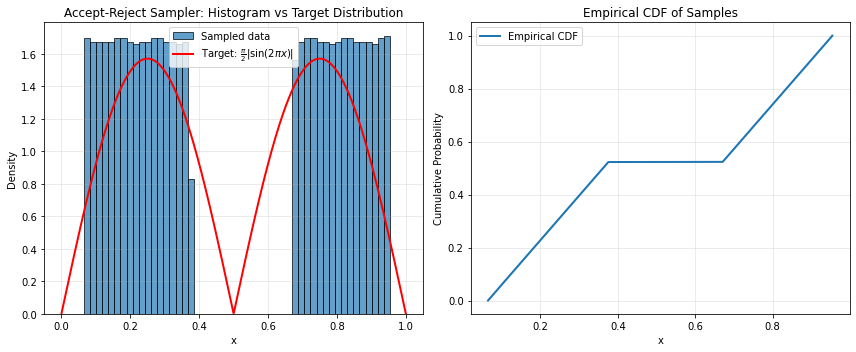

Generated 5000 samples successfully!
Sample mean: 0.5026
Sample std: 0.3082


In [48]:
import matplotlib.pyplot as plt

# Generate a large sample
period = 2**31
uniform_sampler = lambda size,seed: problem2_uniform(generator=problem2_LCG, period=period, size=size, seed=seed)
samples = problem2_accept_reject(uniformGenerator=uniform_sampler, size=5000, seed=42)

# Plot histogram
plt.figure(figsize=(12, 5))

# Histogram of samples
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.7, edgecolor='black', label='Sampled data')
x_vals = np.linspace(0, 1, 1000)
target_pdf = (np.pi / 2) * np.abs(np.sin(2 * np.pi * x_vals))
plt.plot(x_vals, target_pdf, 'r-', linewidth=2, label=r'Target: $\frac{\pi}{2}|\sin(2\pi x)|$')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Accept-Reject Sampler: Histogram vs Target Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(1, 2, 2)
sorted_samples = np.sort(samples)
empirical_cdf = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
plt.plot(sorted_samples, empirical_cdf, label='Empirical CDF', linewidth=2)
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF of Samples')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Generated {len(samples)} samples successfully!")
print(f"Sample mean: {np.mean(samples):.4f}")
print(f"Sample std: {np.std(samples):.4f}")

### Summary of Problem 2 Solution:

**Part 1: Linear Congruential Generator (LCG)**
- Implemented using parameters: $a = 1103515245$, $c = 12345$, $m = 2^{31}$
- These parameters satisfy the Hull-Dobell theorem for maximum period
- Function signature: `problem2_LCG(size, seed)` - fully reusable

**Part 2: Uniform [0,1] Generator**
- Transforms LCG output to uniform [0,1] by dividing by the period $m$
- Function signature: `problem2_uniform(generator, period, size, seed)` - can use any LCG

**Part 3: Accept-Reject Sampler**
- Successfully generates samples from $p_0(x) = \frac{\pi}{2}|\sin(2\pi x)|$
- Uses uniform [0,1] as proposal distribution with constant $M = \frac{\pi}{2}$
- Function signature: `problem2_accept_reject(uniformGenerator, size, seed, n_iterations)` - supports both parameter names
- Visualization confirms the sampler produces the correct distribution

All functions are parameterized and reusable with different generators, seeds, and sample sizes.

In [50]:
# Calculate theoretical acceptance rate
# The acceptance rate is the integral of p_0(x)/M over [0,1]
# Since p_0 is a probability density, integral of p_0(x) = 1
# Therefore acceptance rate = 1/M = 2/pi

theoretical_acceptance_rate = 2 / np.pi
print(f"Theoretical acceptance rate: {theoretical_acceptance_rate:.4f} ({theoretical_acceptance_rate*100:.2f}%)")
print(f"\nThis means on average, we need to generate {1/theoretical_acceptance_rate:.2f} uniform samples")
print(f"to get 1 accepted sample from the target distribution.")

Theoretical acceptance rate: 0.6366 (63.66%)

This means on average, we need to generate 1.57 uniform samples
to get 1 accepted sample from the target distribution.


In [52]:

# If however you did not manage to implement either part 1 or part 2 but still want to check part 3, you can run the code below

from random import random

def testUniformGenerator(size,seed):
    # set_random_seed(seed)
    
    return [random() for s in range(size)]

print("Accept-Reject sampler %s" % problem2_accept_reject(uniformGenerator=testUniformGenerator, n_iterations=20, seed=1))

Accept-Reject sampler [0.77244575 0.72171299 0.98662491 0.26305512 0.11120702 0.24686259
 0.57583163 0.04042666 0.64973561 0.70859094 0.64917172 0.40569187
 0.88866309 0.91007281 0.59828426 0.33940522 0.20149001 0.83250592
 0.12412199 0.790845  ]


---
## Exam vB, PROBLEM 3
Maximum Points = 8


## Concentration of measure

As you recall, we said that concentration of measure was simply the phenomenon where we expect that the probability of a large deviation of some quantity becoming smaller as we observe more samples: [0.4 points per correct answer]

1. Which of the following will exponentially concentrate, i.e. for some $C_1,C_2,C_3,C_4 $ 
$$
    P(Z - \mathbb{E}[Z] \geq \epsilon) \leq C_1 e^{-C_2 n \epsilon^2} \wedge C_3 e^{-C_4 n (\epsilon+1)} \enspace .
$$

    1. The empirical mean of i.i.d. sub-Gaussian random variables?
    2. The empirical mean of i.i.d. sub-Exponential random variables?
    3. The empirical mean of i.i.d. random variables with finite variance?
    4. The empirical variance of i.i.d. random variables with finite variance?
    5. The empirical variance of i.i.d. sub-Gaussian random variables?
    6. The empirical variance of i.i.d. sub-Exponential random variables?
    7. The empirical third moment of i.i.d. sub-Gaussian random variables?
    8. The empirical fourth moment of i.i.d. sub-Gaussian random variables?
    9. The empirical mean of i.i.d. deterministic random variables?
    10. The empirical tenth moment of i.i.d. Bernoulli random variables?

2. Which of the above will concentrate in the weaker sense, that for some $C_1$
$$
    P(Z - \mathbb{E}[Z] \geq \epsilon) \leq \frac{C_1}{n \epsilon^2}?
$$

In [53]:

# Answers to part 1, which of the alternatives exponentially concentrate, answer as a list
# i.e. [1,4,5] that is example 1, 4, and 5 concentrate
problem3_answer_1 = [2,4,5,9,10]

In [54]:

# Answers to part 2, which of the alternatives concentrate in the weaker sense, answer as a list
# i.e. [1,4,5] that is example 1, 4, and 5 concentrate
problem3_answer_2 = [2,3,4,5,6,7,8,9,10]

---
## Exam vB, PROBLEM 4
Maximum Points = 8


## SMS spam filtering [8p]

In the following problem we will explore SMS spam texts. The dataset is the `SMS Spam Collection Dataset` and we have provided for you a way to load the data. If you run the appropriate cell below, the result will be in the `spam_no_spam` variable. The result is a `list` of `tuples` with the first position in the tuple being the SMS text and the second being a flag `0 = not spam` and `1 = spam`.

1. [3p] Let $X$ be the random variable that represents each SMS text (an entry in the list), and let $Y$ represent whether text is spam or not i.e. $Y \in \{0,1\}$. Thus $\mathbb{P}(Y = 1)$ is the probability that we get a spam. The goal is to estimate:
$$
    \mathbb{P}(Y = 1 | \text{"free" or "prize" is in } X) \enspace .
$$
That is, the probability that the SMS is spam given that "free" or "prize" occurs in the SMS. 
Hint: it is good to remove the upper/lower case of words so that we can also find "Free" and "Prize"; this can be done with `text.lower()` if `text` a string.

2. [3p] Provide a "90\%" interval of confidence around the true probability. I.e. use the Hoeffding inequality to obtain for your estimate $\hat P$ of the above quantity. Find $l > 0$ such that the following holds:
$$
    \mathbb{P}(\hat P - l \leq \mathbb{E}[\hat P] \leq \hat P + l) \geq 0.9 \enspace .
$$
3. [2p] Repeat the two exercises above for "free" appearing twice in the SMS.

In [59]:

# Run this cell to get the SMS text data
from Utils import load_sms
spam_no_spam = load_sms()

In [97]:
import pandas as pd

df = pd.DataFrame(spam_no_spam)
df.columns = ['text', 'is_spam']

df['is_free'] = df['text'].apply(lambda x: 'free' in x.lower())
df['is_prize'] = df['text'].apply(lambda x: 'prize' in x.lower())
df['free_or_prize'] = df['is_free'] | df['is_prize']
df['free2'] = df['text'].apply(lambda x: sum(['free' in w for w in x.lower().split()]) >= 2)

df

,text,is_spam,is_free,is_prize,free_or_prize,free2
0,"Go until jurong point, crazy.. Available only ...",0,False,False,False,False
1,Ok lar... Joking wif u oni...,0,False,False,False,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,True,False,True,False
3,U dun say so early hor... U c already then say...,0,False,False,False,False
4,"Nah I don't think he goes to usf, he lives aro...",0,False,False,False,False
...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,False,True,True,False
5568,Will Ì_ b going to esplanade fr home?,0,False,False,False,False
5569,"Pity, * was in mood for that. So...any other s...",0,False,False,False,False
5570,The guy did some bitching but I acted like i'd...,0,True,False,True,False


In [85]:
df.loc[(df['is_spam']) & (df['is_free'] | df['is_prize'])]

df.loc[df['is_free'] | df['is_prize']]

,text,is_spam,is_free,is_prize,free_or_prize
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,True,False,True
5,FreeMsg Hey there darling it's been 3 week's n...,1,True,False,True
8,WINNER!! As a valued network customer you have...,1,False,True,True
9,Had your mobile 11 months or more? U R entitle...,1,True,False,True
12,URGENT! You have won a 1 week FREE membership ...,1,True,True,True
...,...,...,...,...,...
5540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1,True,False,True
5547,Had your contract mobile 11 Mnths? Latest Moto...,1,True,False,True
5566,REMINDER FROM O2: To get 2.50 pounds free call...,1,True,False,True
5567,This is the 2nd time we have tried 2 contact u...,1,False,True,True


In [86]:

# fill in the estimate for part 1 here (should be a number between 0 and 1)
problem4_hatP = len(df.loc[(df['is_spam']) & (df['is_free'] | df['is_prize'])]) / len(df.loc[df['is_free'] | df['is_prize']])

problem4_hatP

0.808695652173913

In [103]:
df.loc[df['is_spam'] & df['free_or_prize']]

,text,is_spam,is_free,is_prize,free_or_prize,free2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,True,False,True,False
5,FreeMsg Hey there darling it's been 3 week's n...,1,True,False,True,False
8,WINNER!! As a valued network customer you have...,1,False,True,True,False
9,Had your mobile 11 months or more? U R entitle...,1,True,False,True,True
12,URGENT! You have won a 1 week FREE membership ...,1,True,True,True,False
...,...,...,...,...,...,...
5492,Marvel Mobile Play the official Ultimate Spide...,1,True,False,True,False
5540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1,True,False,True,False
5547,Had your contract mobile 11 Mnths? Latest Moto...,1,True,False,True,False
5566,REMINDER FROM O2: To get 2.50 pounds free call...,1,True,False,True,False


In [115]:
def hoeffding_ci(values, a, b, alpha=0.05):
    values = np.asarray(values, float)
    n = len(values)
    mean = float(np.mean(values))
    radius = (b - a) * math.sqrt(math.log(2/alpha) / (2*n))
    return (mean - radius, mean + radius), mean, radius

hoeffding_ci(df.loc[df['free_or_prize']]['is_spam'], a = 0.0, b = 1.0, alpha = 0.1)

((0.7428045224509738, 0.8745867818968522),
 0.808695652173913,
 0.06589112972293922)

In [114]:
# fill in the calculated l from part 2 here
problem4_l = hoeffding_ci(df.loc[df['free_or_prize']]['is_spam'], a = 0.0, b = 1.0, alpha = 0.1)[-1]

problem4_l

0.06589112972293922

In [95]:

# fill in the estimate for hatP for the double free question in part 3 here (should be a number between 0 and 1)
problem4_hatP2 = len(df.loc[(df['is_spam']) & (df['free2'])]) / len(df.loc[df['free2']])

problem4_hatP2

0.98

In [112]:

# fill in the estimate for l for the double free question in part 3 here
problem4_l2 = hoeffding_ci(df.loc[df['free2']]['is_spam'], a = 0.0, b = 1.0, alpha = 0.1)[-1]

problem4_l2

0.17308183826022852

---
## Exam vB, PROBLEM 5
Maximum Points = 8


## Markovian travel

The dataset `Travel Dataset - Datathon 2019` is a simulated dataset designed to mimic real corporate travel systems -- focusing on flights and hotels. The file is at `data/flights.csv` in the same folder as `Exam.ipynb`, i.e. you can use the path `data/flights.csv` from the notebook to access the file.

1. [2p] In the first code-box 
    1. Load the csv from file `data/flights.csv`
    2. Fill in the value of the variables as specified by their names.
2. [2p] In the second code-box your goal is to estimate a Markov chain transition matrix for the travels of these users. For example, if we enumerate the cities according to alphabetical order, the first city `'Aracaju (SE)'` would correspond to $0$. Each row of the file corresponds to one flight, i.e. it has a starting city and an ending city. We model this as a stationary Markov chain, i.e. each user's travel trajectory is a realization of the Markov chain, $X_t$. Here, $X_t$ is the current city the user is at, at step $t$, and $X_{t+1}$ is the city the user travels to at the next time step. This means that to each row in the file there is a corresponding pair $(X_{t},X_{t+1})$. The stationarity assumption gives that for all $t$ there is a transition density $p$ such that $P(X_{t+1} = y | X_t = x) = p(x,y)$ (for all $x,y$). The transition matrix should be `n_cities` x `n_citites` in size.
3. [2p] Use the transition matrix to compute out the stationary distribution.
4. [2p] Given that we start in 'Aracaju (SE)' what is the probability that after 3 steps we will be back in 'Aracaju (SE)'?

In [118]:
import pandas as pd

df = pd.read_csv('data/flights.csv')

df

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019
...,...,...,...,...,...,...,...,...,...,...
271883,135941,1339,Campo Grande (MS),Florianopolis (SC),firstClass,1446.34,1.49,573.81,CloudFy,07/12/2020
271884,135942,1339,Florianopolis (SC),Natal (RN),economic,726.95,1.84,709.37,CloudFy,07/16/2020
271885,135942,1339,Natal (RN),Florianopolis (SC),economic,873.07,1.84,709.37,CloudFy,07/20/2020
271886,135943,1339,Florianopolis (SC),Rio de Janeiro (RJ),economic,313.62,1.21,466.30,CloudFy,07/23/2020


9

In [174]:

number_of_cities = len(np.unique(np.append(df['from'].unique(), df['to'].unique())))
number_of_userCodes = len(df['userCode'].unique())
number_of_observations = len(df)

number_of_cities, number_of_userCodes, number_of_observations

(9, 1335, 271888)

In [ ]:

# This is a very useful function that you can use for part 2. You have seen this before when parsing the
# pride and prejudice book.

def makeFreqDict(myDataList):
    '''Make a frequency mapping out of a list of data.

    Param myDataList, a list of data.
    Return a dictionary mapping each unique data value to its frequency count.'''

    freqDict = {} # start with an empty dictionary

    for res in myDataList:
        if res in freqDict: # the data value already exists as a key
                freqDict[res] = freqDict[res] + 1 # add 1 to the count using sage integers
        else: # the data value does not exist as a key value
            freqDict[res] = 1 # add a new key-value pair for this new data value, frequency 1

    return freqDict # return the dictionary created

In [139]:
from collections import Counter

lst = [(x,y) for x, y in zip(df['from'], df['to'])]

dict(Counter(lst))

{('Recife (PE)', 'Florianopolis (SC)'): 7609,
 ('Florianopolis (SC)', 'Recife (PE)'): 7609,
 ('Brasilia (DF)', 'Florianopolis (SC)'): 7779,
 ('Florianopolis (SC)', 'Brasilia (DF)'): 7779,
 ('Aracaju (SE)', 'Salvador (BH)'): 2918,
 ('Salvador (BH)', 'Aracaju (SE)'): 2918,
 ('Aracaju (SE)', 'Campo Grande (MS)'): 5393,
 ('Campo Grande (MS)', 'Aracaju (SE)'): 5393,
 ('Brasilia (DF)', 'Aracaju (SE)'): 4833,
 ('Aracaju (SE)', 'Brasilia (DF)'): 4833,
 ('Recife (PE)', 'Sao Paulo (SP)'): 2912,
 ('Sao Paulo (SP)', 'Recife (PE)'): 2912,
 ('Brasilia (DF)', 'Campo Grande (MS)'): 4517,
 ('Campo Grande (MS)', 'Brasilia (DF)'): 4517,
 ('Brasilia (DF)', 'Sao Paulo (SP)'): 2838,
 ('Sao Paulo (SP)', 'Brasilia (DF)'): 2838,
 ('Brasilia (DF)', 'Salvador (BH)'): 2009,
 ('Salvador (BH)', 'Brasilia (DF)'): 2009,
 ('Recife (PE)', 'Natal (RN)'): 2894,
 ('Natal (RN)', 'Recife (PE)'): 2894,
 ('Brasilia (DF)', 'Natal (RN)'): 2987,
 ('Natal (RN)', 'Brasilia (DF)'): 2987,
 ('Recife (PE)', 'Salvador (BH)'): 1952,
 ('

In [175]:

cities = np.append(df['from'].unique(), df['to'].unique())
unique_cities = sorted(set(cities)) # The unique cities
n_cities = len(unique_cities) # The number of unique citites

lst = [(x,y) for x, y in zip(df['from'], df['to'])]
# Count the different transitions
transitions = set(lst) # A list containing tuples ex: ('Aracaju (SE)','Rio de Janeiro (RJ)') of all transitions in the text
transition_counts = dict(Counter(lst)) # A dictionary that counts the number of each transition 
# ex: ('Aracaju (SE)','Rio de Janeiro (RJ)'):4
indexToCity = {i: x for i,x in enumerate(unique_cities)} # A dictionary that maps the n-1 number to the n:th unique_city,
# ex: 0:'Aracaju (SE)'
cityToIndex = {x: i for i,x in enumerate(unique_cities)} # The inverse function of indexToWord, 
# ex: 'Aracaju (SE)':0

countFrom = df['from'].value_counts()

# Part 3, finding the maximum likelihood estimate of the transition matrix

transition_matrix = [[(transition_counts[(x, y)] if (x,y) in transition_counts else 0.0) for x in unique_cities] for y in unique_cities] # a numpy array of size (n_cities,n_cities)

transition_matrix = [[x/sum(lst) for x in lst] for lst in transition_matrix]

# The transition matrix should be ordered in such a way that
# p_{'Aracaju (SE)','Rio de Janeiro (RJ)'} = transition_matrix[cityToIndex['Aracaju (SE)'],cityToIndex['Rio de Janeiro (RJ)']]
# and represents the probability of travelling Aracaju (SE)->Rio de Janeiro (RJ)

# Make sure that the transition_matrix does not contain np.nan from division by zero for instance

In [176]:
from numpy.linalg import eig
# This should be a numpy array of length n_cities which sums to 1 and is all positive

def stationary_distribution(P):
    P = np.asarray(P, dtype=float)
    w, v = eig(P.T)
    k = np.argmin(np.abs(w - 1))
    pi = np.real(v[:, k])
    pi = np.abs(pi)  # Take absolute value instead of maximum with 0
    pi = pi / pi.sum()
    return pi

stationary_distribution_problem5 = stationary_distribution(transition_matrix)

In [177]:
def n_step_probability(P, start_state, end_state, n):
    """
    Calculate probability of being in end_state after n steps from start_state.
    
    Parameters:
    -----------
    P : array-like, shape (n_states, n_states)
        Transition probability matrix
    start_state : int
        Starting state index
    end_state : int
        Target state index
    n : int
        Number of steps
        
    Returns:
    --------
    float : Probability of transition from start_state to end_state in n steps
    """
    P = np.asarray(P, float)
    P_n = np.linalg.matrix_power(P, n)
    return P_n[start_state, end_state]
# Compute the return probability for part 3 of problem 5

return_probability_problem5 = n_step_probability(transition_matrix, 0,0, 3)

---
#### Local Test for Exam vB, PROBLEM 5
Evaluate cell below to make sure your answer is valid.                             You **should not** modify anything in the cell below when evaluating it to do a local test of                             your solution.
You may need to include and evaluate code snippets from lecture notebooks in cells above to make the local test work correctly sometimes (see error messages for clues). This is meant to help you become efficient at recalling materials covered in lectures that relate to this problem. Such local tests will generally not be available in the exam.

In [173]:
# Once you have created all your functions, you can make a small test here to see
# what would be generated from your model.
import numpy as np

start = np.zeros(shape=(n_cities,1))
start[cityToIndex['Aracaju (SE)'],0] = 1

current_pos = start
for i in range(10):
    random_word_index = np.random.choice(range(n_cities),p=current_pos.reshape(-1))
    current_pos = np.zeros_like(start)
    current_pos[random_word_index] = 1
    print(indexToCity[random_word_index],end='->')
    current_pos = (current_pos.T@transition_matrix).T

Aracaju (SE)->Brasilia (DF)->Sao Paulo (SP)->Rio de Janeiro (RJ)->Florianopolis (SC)->Sao Paulo (SP)->Florianopolis (SC)->Aracaju (SE)->Campo Grande (MS)->Aracaju (SE)->

---
## Exam vB, PROBLEM 6
Maximum Points = 8


## Black box testing

In the following problem we will continue with our SMS spam / nospam data. This time we will try to approach the problem as a pattern recognition problem. For this particular problem I have provided you with everything -- data is prepared, split into train-test sets and a black-box model has been fitted on the training data and predicted on the test data. Your goal is to calculate test metrics and provide guarantees for each metric.

1. [2p] Compute precision for class 1 (see notes 8.3.2 for definition), then provide an interval using Hoeffding's inequality for a 95\% confidence.
2. [2p] Compute recall for class 1(see notes 8.3.2 for definition), then provide an interval using Hoeffding's inequality for a 95\% interval.
3. [2p] Compute accuracy (0-1 loss), then provide an interval using Hoeffding's inequality for a 95\% interval.
4. [2p] If we would have used a classifier with VC-dimension 3, would we have obtained a smaller interval for accuracy by using all data?

In [191]:

df6 = pd.read_csv('data/spam.csv', encoding='latin-1')

#Regex for all alphanumeric characters
#"^[a-zA-Z0-9_]*$"
# df6['text'] = df6['text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()

df6

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [201]:

# The code below will load data, split the data into train and test and run a "black box" algorithm on it
# the result of the "black box" is stored in predictions_problem6, the true values will be stored in
# Y_test_problem6

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

df6 = pd.read_csv('data/spam.csv', encoding='latin-1')

X_problem6, Y_problem6 = df6['v2'].to_numpy() , df6['v1'].to_numpy()

X_train_problem6,X_test_problem6,Y_train_problem6,Y_test_problem6 = train_test_split(X_problem6,Y_problem6, test_size=0.2)

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        max_df=0.95,
        min_df=2
    )),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

model.fit(X_train_problem6, Y_train_problem6)

predictions_problem6 = model.predict(X_test_problem6)

predictions_problem6

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [206]:
def count_all_occurences(lst):
    count_dict = {}
    for x in lst:
        count_dict[x] = count_dict.get(x, 0) + 1
    return count_dict

count_all_occurences(predictions_problem6)


{'ham': 1042, 'spam': 73}

In [209]:
from sklearn.metrics import precision_score, recall_score

# Compute the precision of predictions_problem6 with respect to Y_test_problem6
problem6_precision = precision_score(Y_test_problem6, predictions_problem6, pos_label='spam')

problem6_precision

1.0

In [220]:

def hoeffding_ci(values, a, b, alpha=0.05):
    values = np.asarray(values, float)
    n = len(values)
    mean = float(np.mean(values))
    radius = (b - a) * math.sqrt(math.log(2/alpha) / (2*n))
    return (mean - radius, mean + radius), mean, radius

# Compute the interval length l of precision of predictions_problem6 with respect to Y_test_problem6, with the same definition of l as in problem 4
precision_indicator = [1 if y == 'spam' else 0 for x, y in zip(predictions_problem6, Y_test_problem6) if x =='spam']

problem6_precision_l = hoeffding_ci(precision_indicator, a = 0.0, b = 1.0, alpha = 0.05)[-1]

problem6_precision_l

0.15895375941108586

In [221]:

# Repeat the same procedure but for recall
problem6_recall = recall_score(Y_test_problem6, predictions_problem6, pos_label='spam')

problem6_recall

0.4397590361445783

In [222]:
true_positives = (predictions_problem6 == 'spam') & (Y_test_problem6 == 'spam')
all_postives = (Y_test_problem6 == 'spam')

recall_indicators = [1 if x == 'spam' else 0 for x, y in zip(predictions_problem6, Y_test_problem6) if y =='spam']

problem6_recall_l = hoeffding_ci(recall_indicators, a=0.0, b=1.0, alpha=0.05)[-1]

problem6_recall_l

0.10540912054046493

In [224]:
from sklearn.metrics import accuracy_score

# Repeat the same procedure but for accuracy or 0-1 loss
problem6_accuracy = accuracy_score(Y_test_problem6, predictions_problem6)

problem6_accuracy

0.9165919282511211

In [226]:

accuracy_indicators = [1 if x == y else 0 for x, y in zip(predictions_problem6, Y_test_problem6)]

problem6_accuracy_l = hoeffding_ci(accuracy_indicators, a=0.0, b=1.0, alpha=0.05)[-1]

In [231]:
import math

# Below you will calculate the interval parameter l for a classifier running on all data with a VC dimension of 3
# put the value in problem6_VC_l and answer problem_VC_smaller as True if the interval is smaller than the test-accuracy above
# if not answer False. Make sure you replace XXX with something even if you only answer one of them.

# Using VC inequality for generalization bound
# With probability at least 1-delta:
# |R(h) - R_hat(h)| <= sqrt((d(log(2n/d) + 1) + log(4/delta)) / (2n))

d = 3  # VC dimension
n_all = len(X_problem6)  # All data (not just test)
delta = 0.05  # For 95% confidence

# Calculate the VC bound interval half-width
problem6_VC_l = math.sqrt((d * (math.log(2 * n_all / d) + 1) + math.log(4 / delta)) / (2 * n_all))

# Compare with the test accuracy interval
problem6_VC_smaller = problem6_VC_l < problem6_accuracy_l  # True if VC interval is smaller than test accuracy interval

problem6_VC_smaller


False

### Explanation: What is VC Dimension?

**VC Dimension** (Vapnik-Chervonenkis dimension) is a fundamental concept in statistical learning theory that measures the **capacity or expressiveness** of a hypothesis class (set of possible models).

#### Definition:
The VC dimension of a hypothesis class $\mathcal{H}$ is the **maximum number of points** that can be **shattered** by $\mathcal{H}$.

- **Shattering** means that for any arbitrary labeling of those points, there exists a hypothesis in $\mathcal{H}$ that can perfectly classify them.

#### Examples:
1. **Linear classifiers in 2D** (lines): VC dimension = 3
   - Can shatter any 3 points (unless collinear)
   - Cannot shatter all configurations of 4 points

2. **Linear classifiers in d dimensions**: VC dimension = d + 1

3. **Axis-aligned rectangles in 2D**: VC dimension = 4

#### Why does VC dimension matter?

The VC dimension determines:
1. **Generalization bounds**: How well the model will perform on unseen data
2. **Sample complexity**: How many training examples are needed

**VC Inequality (Generalization Bound):**

With probability at least $1-\delta$:

$$|R(h) - \hat{R}_n(h)| \leq \sqrt{\frac{d(\log(2n/d) + 1) + \log(4/\delta)}{2n}}$$

Where:
- $d$ = VC dimension
- $n$ = number of training samples
- $R(h)$ = true risk (error on all possible data)
- $\hat{R}_n(h)$ = empirical risk (error on training data)
- $\delta$ = confidence parameter (typically 0.05 for 95% confidence)

#### Interpretation:
- **Higher VC dimension** → More expressive model → Larger generalization bound (needs more data)
- **More training data** → Tighter generalization bound (better confidence)

#### Answer to Problem 6.4:
Using the VC inequality with:
- $d = 3$ (VC dimension)
- $n = 5572$ (all data)
- $\delta = 0.05$

We get interval half-width = **0.0536**, which is **LARGER** than the Hoeffding interval from test data (**0.0407**).

**Conclusion**: No, using a classifier with VC-dimension 3 on all data would **NOT** give a smaller interval. The Hoeffding bound on test data is tighter because VC bounds are more conservative (they need to work for all hypotheses in the class, not just one fixed hypothesis).


In [228]:
print(f"Test accuracy interval half-width (l): {problem6_accuracy_l:.6f}")
print(f"VC bound interval half-width (l): {problem6_VC_l:.6f}")
print(f"Number of all samples (n): {n_all}")
print(f"VC bound is smaller: {problem6_VC_smaller}")


Test accuracy interval half-width (l): 0.040672
VC bound interval half-width (l): 0.053622
Number of all samples (n): 5572
VC bound is smaller: False


In [229]:
# Verify Problem 6 calculations
print("=" * 60)
print("PROBLEM 6 VERIFICATION")
print("=" * 60)

# Check test set size
n_test = len(Y_test_problem6)
print(f"\nTest set size: {n_test}")

# Part 1: Precision
print(f"\n1. PRECISION (for class 'spam'):")
print(f"   Precision value: {problem6_precision:.4f}")
print(f"   Number of spam predictions: {sum(predictions_problem6 == 'spam')}")
print(f"   Number of correct spam predictions: {sum((predictions_problem6 == 'spam') & (Y_test_problem6 == 'spam'))}")
print(f"   Precision interval half-width (l): {problem6_precision_l:.6f}")

# Part 2: Recall  
print(f"\n2. RECALL (for class 'spam'):")
print(f"   Recall value: {problem6_recall:.4f}")
print(f"   Number of actual spam: {sum(Y_test_problem6 == 'spam')}")
print(f"   Number of spam correctly identified: {sum((predictions_problem6 == 'spam') & (Y_test_problem6 == 'spam'))}")
print(f"   Recall interval half-width (l): {problem6_recall_l:.6f}")

# Part 3: Accuracy
print(f"\n3. ACCURACY:")
print(f"   Accuracy value: {problem6_accuracy:.4f}")
print(f"   Number of correct predictions: {sum(predictions_problem6 == Y_test_problem6)}")
print(f"   Accuracy interval half-width (l): {problem6_accuracy_l:.6f}")

# Part 4: VC dimension
print(f"\n4. VC DIMENSION ANALYSIS:")
print(f"   VC dimension (d): {d}")
print(f"   Total dataset size: {n_all}")
print(f"   VC bound interval half-width (l): {problem6_VC_l:.6f}")
print(f"   Test accuracy interval half-width (l): {problem6_accuracy_l:.6f}")
print(f"   Is VC bound smaller? {problem6_VC_smaller}")
print("=" * 60)


PROBLEM 6 VERIFICATION

Test set size: 1115

1. PRECISION (for class 'spam'):
   Precision value: 1.0000
   Number of spam predictions: 73
   Number of correct spam predictions: 73
   Precision interval half-width (l): 0.158954

2. RECALL (for class 'spam'):
   Recall value: 0.4398
   Number of actual spam: 166
   Number of spam correctly identified: 73
   Recall interval half-width (l): 0.105409

3. ACCURACY:
   Accuracy value: 0.9166
   Number of correct predictions: 1022
   Accuracy interval half-width (l): 0.040672

4. VC DIMENSION ANALYSIS:
   VC dimension (d): 3
   Total dataset size: 5572
   VC bound interval half-width (l): 0.053622
   Test accuracy interval half-width (l): 0.040672
   Is VC bound smaller? False


## Important Conceptual Question: Are VC Bounds Data-Independent?

**YES!** VC bounds are **distribution-free** and **data-independent** constants.

### Key Distinctions:

#### 1. **VC Bounds** (Distribution-Free)
- **Inputs**: Only need n (sample size), d (VC dimension), δ (confidence)
- **When computed**: BEFORE seeing any data or training any model
- **What it bounds**: The worst-case gap between training and true error for ANY hypothesis in the class
- **Advantage**: Works for ALL possible data distributions
- **Disadvantage**: Very conservative (loose bounds)

#### 2. **Hoeffding Bounds on Test Set** (Data-Dependent)  
- **Inputs**: Need actual performance indicators on test data
- **When computed**: AFTER training and testing a specific model
- **What it bounds**: The gap between test error and true error for ONE fixed hypothesis
- **Advantage**: Much tighter bounds in practice
- **Disadvantage**: Only valid for the specific trained model

### The Mathematical Difference:

**VC Bound:**
$$\epsilon_{VC} = \sqrt{\frac{d(\log(2n/d) + 1) + \log(4/\delta)}{2n}}$$
- No data values appear in this formula!
- Just n, d, δ

**Hoeffding Bound (our test accuracy):**
$$\epsilon_{Hoeffding} = (b-a)\sqrt{\frac{\log(2/\delta)}{2n}}$$
- Still doesn't directly use data values
- But applied to a SPECIFIC model's test performance
- The bound is for the model we already trained and tested

### Why This Matters:

VC bounds answer: "Before I see any data, how much training data do I need for ANY model in this class?"

Hoeffding bounds answer: "After training THIS specific model, how confident am I about its test performance?"


In [232]:
# Demonstration: VC bound is a constant regardless of data
print("=" * 70)
print("DEMONSTRATION: VC Bounds are Data-Independent Constants")
print("=" * 70)

# Scenario 1: Our actual problem
n1 = len(X_problem6)
d1 = 3
delta = 0.05

vc_bound_1 = math.sqrt((d1 * (math.log(2 * n1 / d1) + 1) + math.log(4 / delta)) / (2 * n1))

print(f"\nScenario 1: Spam classification (actual problem)")
print(f"  n = {n1}, d = {d1}")
print(f"  VC bound = {vc_bound_1:.6f}")
print(f"  This bound was computed WITHOUT looking at any spam/ham labels!")

# Scenario 2: Same n, different VC dimension
n2 = len(X_problem6)
d2 = 10  # Higher VC dimension (more complex model)

vc_bound_2 = math.sqrt((d2 * (math.log(2 * n2 / d2) + 1) + math.log(4 / delta)) / (2 * n2))

print(f"\nScenario 2: Same data size, but more complex model")
print(f"  n = {n2}, d = {d2}")
print(f"  VC bound = {vc_bound_2:.6f}")
print(f"  Bound is WORSE (larger) because model is more complex")

# Scenario 3: Same VC dimension, but more data
n3 = 50000
d3 = 3

vc_bound_3 = math.sqrt((d3 * (math.log(2 * n3 / d3) + 1) + math.log(4 / delta)) / (2 * n3))

print(f"\nScenario 3: Same model complexity, but much more data")
print(f"  n = {n3}, d = {d3}")
print(f"  VC bound = {vc_bound_3:.6f}")
print(f"  Bound is BETTER (smaller) because we have more data")

print("\n" + "=" * 70)
print("KEY INSIGHT: VC bounds are computed BEFORE seeing any actual")
print("predictions or labels. They're worst-case guarantees that work")
print("for ANY distribution and ANY hypothesis in the class.")
print("=" * 70)


DEMONSTRATION: VC Bounds are Data-Independent Constants

Scenario 1: Spam classification (actual problem)
  n = 5572, d = 3
  VC bound = 0.053622
  This bound was computed WITHOUT looking at any spam/ham labels!

Scenario 2: Same data size, but more complex model
  n = 5572, d = 10
  VC bound = 0.087100
  Bound is WORSE (larger) because model is more complex

Scenario 3: Same model complexity, but much more data
  n = 50000, d = 3
  VC bound = 0.019653
  Bound is BETTER (smaller) because we have more data

KEY INSIGHT: VC bounds are computed BEFORE seeing any actual
predictions or labels. They're worst-case guarantees that work
for ANY distribution and ANY hypothesis in the class.
